In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='SimHei', size=11)  ##显示中文
import jieba
# from wordcloud import WordCloud, STOPWORDS
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm_notebook as tqdm
import IPython.core.display as di 
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_seq_items', 300)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 20)

c:\users\dechen\appdata\local\programs\python\python36\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## 作何使用？

In [2]:
# model_file = '../../data/word2vec_models/sgns.baidubaike.bigram-char'
# print('create embedding matrix')

# # [print(o) for o in open(model_file, 'r', encoding='UTF-8').readlines()[1:100]]

# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(model_file, 'r', encoding='UTF-8').readlines()[1:])

In [3]:
# jp_df = pd.read_csv('../../data/csvs/round2zh2jp.csv')
# en_df = pd.read_csv('../../data/csvs/round2zh2en.csv')

# def cut(cut_df):
#     chars = []
#     words = []
#     for s in tqdm(cut_df['text']):
#         s = str(s)
#         chars.append(' '.join(list(s)).strip())
#         words.append(' '.join(jieba.cut(s, cut_all=False)).strip())
#     os.makedirs('../../data/csvs', exist_ok=True)
#     cut_df['word'] = words
#     cut_df['char'] = chars
#     return cut_df
# jp_df = cut(jp_df)
# en_df = cut(en_df)

## 切词并保存

In [4]:
train_df = pd.read_csv('../../data/raw_data/train_2.csv')
test_df = pd.read_csv('../../data/raw_data/test_public_2v3.csv')

# len(test_df[test_df.apply(lambda x:x['subject'] in x['content'], axis=1)])
print(train_df['sentiment_value'].value_counts())
print(len(train_df))

 0    8488
 1    2048
-1    2036
Name: sentiment_value, dtype: int64
12572


In [5]:
# 只在第一次进入cell时运行

def cut(cut_df):
    chars = []
    words = []
    for s in tqdm(cut_df['content']):
        chars.append(' '.join(list(s)).strip())
        words.append(' '.join(jieba.cut(s, cut_all=False)).strip())
    os.makedirs('../../data/csvs', exist_ok=True)
    cut_df['word'] = words
    cut_df['char'] = chars
    return cut_df

test_cut_df = cut(test_df)
train_cut_df = cut(train_df)

test_cut_df.to_csv('../../data/csvs/test_public.csv', index=None)
train_cut_df.to_csv('../../data/csvs/train.csv', index=None)

# test_cut_df = pd.read_csv('../../data/csvs/test_public.csv')
# train_cut_df = pd.read_csv('../../data/csvs/train.csv')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\dechen\AppData\Local\Temp\jieba.cache
Loading model cost 0.782 seconds.
Prefix dict has been built succesfully.


## 处理Label-十种四分类

In [6]:
sub_list = ['subject_价格', 'subject_内饰', 'subject_动力', 'subject_外观', 'subject_安全性',
            'subject_油耗', 'subject_空间', 'subject_舒适性', 'subject_操控', 'subject_配置']
pickle.dump(sub_list, open('../../data/sub_list.pkl', 'wb'))
columns = ['content_id', 'content', 'word', 'char', 'sentiment_word']
columns.extend(sub_list)
train_df_final = pd.DataFrame(columns=columns)

for i in tqdm(range(len(train_cut_df))):
    c_id = train_cut_df.iloc[i]['content_id']
    subject_str = 'subject_' + train_cut_df.iloc[i]['subject']
    sent_val = train_cut_df.iloc[i]['sentiment_value']
    
    if c_id in set(train_df_final['content_id'].values):
        #将情感值映射到{1,2,3}集合
        train_df_final[subject_str][train_df_final['content_id'] == c_id] = sent_val + 2
        
    else:
        sub_dict = {k:0 for k in sub_list}
        sub_dict[subject_str] = sent_val + 2
        content_dict = {
            'content_id': c_id,
            'content': train_cut_df.iloc[i]['content'],
            'word' : train_cut_df.iloc[i]['word'],
            'char' : train_cut_df.iloc[i]['char'],
            'sentiment_word' : train_cut_df.iloc[i]['sentiment_word'],
        }
        content_dict.update(sub_dict)
        train_df_final.loc[train_df_final.shape[0]] = content_dict

In [7]:
print(train_df_final.shape)
train_df_final.head()

(10654, 15)


,content_id,content,word,char,sentiment_word,subject_价格,subject_内饰,subject_动力,subject_外观,subject_安全性,subject_油耗,subject_空间,subject_舒适性,subject_操控,subject_配置
0,13149,因为森林人即将换代，这套系统没必...,因为 森林 人 即将 换代 ， ...,因 为 森 林 人 即 将 换 ...,影响,2,0,0,0,0,0,0,0,0,0
1,2288,四驱价格貌似挺高的，高的可以看齐...,四驱 价格 貌似 挺 高 的 ，...,四 驱 价 格 貌 似 挺 高 ...,高,1,0,0,0,0,0,0,0,0,0
2,1652,斯柯达要说质量，似乎比大众要好一...,斯柯达 要说 质量 ， 似乎 比...,斯 柯 达 要 说 质 量 ， ...,低,3,0,0,0,0,0,0,0,0,0
3,8865,这玩意都是给有钱任性又不懂车的土...,这 玩意 都 是 给 有钱 任性...,这 玩 意 都 是 给 有 钱 ...,有钱任性,1,0,0,0,0,0,0,0,0,0
4,11784,17价格忒高，估计也就是14-1...,17 价格 忒 高 ， 估计 也...,1 7 价 格 忒 高 ， 估 ...,高,1,0,0,0,0,0,0,0,0,0


In [8]:
print(len(train_df[train_df.duplicated(['content_id', 'content'])]))
print(len(train_df))
print(len(train_df_final))

#多于一个主题标签的样本数
multi_item_df = train_df_final[train_df_final[train_df_final[sub_list] > 0].count(axis=1) > 1]
len(multi_item_df)

1918
12572
10654


1472

In [9]:
train_df_final.head(100)

,content_id,content,word,char,sentiment_word,subject_价格,subject_内饰,subject_动力,subject_外观,subject_安全性,subject_油耗,subject_空间,subject_舒适性,subject_操控,subject_配置
0,13149,因为森林人即将换代，这套系统没必...,因为 森林 人 即将 换代 ， ...,因 为 森 林 人 即 将 换 ...,影响,2,0,0,0,0,0,0,0,0,0
1,2288,四驱价格貌似挺高的，高的可以看齐...,四驱 价格 貌似 挺 高 的 ，...,四 驱 价 格 貌 似 挺 高 ...,高,1,0,0,0,0,0,0,0,0,0
2,1652,斯柯达要说质量，似乎比大众要好一...,斯柯达 要说 质量 ， 似乎 比...,斯 柯 达 要 说 质 量 ， ...,低,3,0,0,0,0,0,0,0,0,0
3,8865,这玩意都是给有钱任性又不懂车的土...,这 玩意 都 是 给 有钱 任性...,这 玩 意 都 是 给 有 钱 ...,有钱任性,1,0,0,0,0,0,0,0,0,0
4,11784,17价格忒高，估计也就是14-1...,17 价格 忒 高 ， 估计 也...,1 7 价 格 忒 高 ， 估 ...,高,1,0,0,0,0,0,0,0,0,0
5,14601,我开始就是荣放2.5 森林人2...,我 开始 就是 荣放 2.5 ...,我 开 始 就 是 荣 放 2 ...,便宜,3,0,0,0,0,0,0,0,0,0
6,15972,唉，这货的价格死硬死硬的，低配版...,唉 ， 这货 的 价格 死硬 死...,唉 ， 这 货 的 价 格 死 ...,死硬,1,0,0,0,0,0,0,0,0,0
7,17103,价格的话只能说一般般吧，太仓前段...,价格 的话 只能 说 一般般 吧...,价 格 的 话 只 能 说 一 ...,一般,2,0,0,0,0,0,0,0,0,0
8,1986,听过，价格太贵，但一直念念不忘,听过 ， 价格 太贵 ， 但 一...,听 过 ， 价 格 太 贵 ， ...,贵,1,0,0,0,0,0,0,0,0,0
9,3234,恭喜恭喜，这个优惠不错哦！,恭喜 恭喜 ， 这个 优惠 不错...,恭 喜 恭 喜 ， 这 个 优 ...,优惠,2,0,0,0,0,0,0,0,0,0


In [10]:
# 统计类别比
labels = train_df_final.iloc[:, 5:].values
labels_dict = {} #统计具有相同数量标签的样本数量，{标签数，[样本索引]}

for idx,l in enumerate(labels):
    n_l = np.sum(l>0)
    labels_dict[n_l] = labels_dict.get(n_l, 0) + 1

n_c0 = np.sum(labels == 0)
n_c1 = np.sum(labels == 1)
n_c2 = np.sum(labels == 2)
n_c3 = np.sum(labels == 3)
n_total = n_c0 + n_c1 + n_c2 + n_c3
w_c0 = n_c0 / n_total
w_c1 = n_c1 / n_total
w_c2 = n_c2 / n_total
w_c3 = n_c3 / n_total
w_c0, w_c1, w_c2, w_c3

(0.8819973718791064,
 0.019110193354608597,
 0.07966960765909517,
 0.019222827107189786)

## 处理label-组合单分类

In [11]:
###按照原始train数据将主体和情感值组合成一个属性

def generate_label():
    df = train_cut_df.copy()
    label_stoi = {}
    def combine_label(a, b):
        return '{}-{}'.format(a, b+1)
    df['class'] = df.apply(lambda row: combine_label(row['subject'], row['sentiment_value']), axis=1)
    for c in df['class'].value_counts().index:
        label_stoi[c] = len(label_stoi)
    df['c_numerical'] = df.apply(lambda row: label_stoi[row['class']], axis=1)
    return label_stoi, df
label_stoi, df = generate_label()
print(label_stoi)
pickle.dump(label_stoi, open('../../data/single_label_stoi.pkl', 'wb'))
df.to_csv('../../data/csvs/train_single.csv')
df[:5]

{'动力-1': 0, '价格-1': 1, '油耗-1': 2, '操控-1': 3, '配置-1': 4, '舒适性-1': 5, '安全性-1': 6, '动力-0': 7, '动力-2': 8, '操控-2': 9, '内饰-1': 10, '外观-1': 11, '舒适性-0': 12, '空间-1': 13, '配置-0': 14, '油耗-2': 15, '内饰-0': 16, '价格-0': 17, '空间-2': 18, '油耗-0': 19, '操控-0': 20, '配置-2': 21, '价格-2': 22, '舒适性-2': 23, '内饰-2': 24, '外观-2': 25, '外观-0': 26, '安全性-2': 27, '安全性-0': 28, '空间-0': 29}


,content_id,content,subject,sentiment_value,sentiment_word,word,char,class,c_numerical
0,13149,因为森林人即将换代，这套系统没必...,价格,0,影响,因为 森林 人 即将 换代 ， ...,因 为 森 林 人 即 将 换 ...,价格-1,1
1,2288,四驱价格貌似挺高的，高的可以看齐...,价格,-1,高,四驱 价格 貌似 挺 高 的 ，...,四 驱 价 格 貌 似 挺 高 ...,价格-0,17
2,1652,斯柯达要说质量，似乎比大众要好一...,价格,1,低,斯柯达 要说 质量 ， 似乎 比...,斯 柯 达 要 说 质 量 ， ...,价格-2,22
3,8865,这玩意都是给有钱任性又不懂车的土...,价格,-1,有钱任性,这 玩意 都 是 给 有钱 任性...,这 玩 意 都 是 给 有 钱 ...,价格-0,17
4,11784,17价格忒高，估计也就是14-1...,价格,-1,高,17 价格 忒 高 ， 估计 也...,1 7 价 格 忒 高 ， 估 ...,价格-0,17


## 处理Label-先分主题后分情感

In [12]:
def generate_label():
    df = train_cut_df.copy()
    label_stoi = {}
    for c in df['subject'].value_counts().index:
        label_stoi[c] = len(label_stoi)
    df['sub_numerical'] = df.apply(lambda row: label_stoi[row['subject']], axis=1)
    df['sentiment_value'] = df.apply(lambda row: row['sentiment_value']+1, axis=1)
    return label_stoi, df
label_stoi, df = generate_label()

os.makedirs('../../data/csvs', exist_ok=True)
pickle.dump(label_stoi, open('../../data/subject_label_stoi.pkl', 'wb'))
df.to_csv('../../data/csvs/train_single_label.csv')
df[:5]

,content_id,content,subject,sentiment_value,sentiment_word,word,char,sub_numerical
0,13149,因为森林人即将换代，这套系统没必...,价格,1,影响,因为 森林 人 即将 换代 ， ...,因 为 森 林 人 即 将 换 ...,1
1,2288,四驱价格貌似挺高的，高的可以看齐...,价格,0,高,四驱 价格 貌似 挺 高 的 ，...,四 驱 价 格 貌 似 挺 高 ...,1
2,1652,斯柯达要说质量，似乎比大众要好一...,价格,2,低,斯柯达 要说 质量 ， 似乎 比...,斯 柯 达 要 说 质 量 ， ...,1
3,8865,这玩意都是给有钱任性又不懂车的土...,价格,0,有钱任性,这 玩意 都 是 给 有钱 任性...,这 玩 意 都 是 给 有 钱 ...,1
4,11784,17价格忒高，估计也就是14-1...,价格,0,高,17 价格 忒 高 ， 估计 也...,1 7 价 格 忒 高 ， 估 ...,1


In [13]:
df.columns[2:]

Index(['subject', 'sentiment_value', 'sentiment_word', 'word', 'char',
       'sub_numerical'],
      dtype='object')

## 多标签分类，主题情感一起分

,content_id,word,char,class
0,13149,因为 森林 人 即将 换代 ， ...,因 为 森 林 人 即 将 换 ...,价格_0
1,2288,四驱 价格 貌似 挺 高 的 ，...,四 驱 价 格 貌 似 挺 高 ...,价格_-1
2,1652,斯柯达 要说 质量 ， 似乎 比...,斯 柯 达 要 说 质 量 ， ...,价格_1


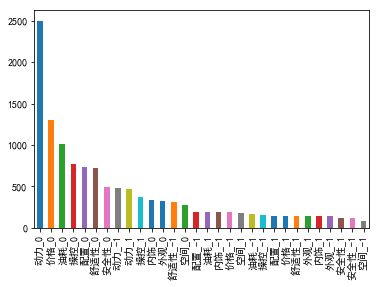

In [14]:
train_multi_df = train_cut_df[['content_id', 'word', 'char']]
train_multi_df['class'] = train_cut_df.apply(lambda row: '{}_{}'.format(row['subject'],row['sentiment_value']), axis=1)
train_multi_df['class'].value_counts().plot(kind='bar')
train_multi_df[:3]

In [15]:
if '价格_0' not in train_multi_df.columns:
    train_multi_df = pd.concat((train_multi_df, pd.get_dummies(train_multi_df['class'])), axis=1)

train_multi_df = train_multi_df.groupby(['content_id', 'word', 'char']).sum().reset_index(drop=False)
train_multi_df[:3]

,content_id,word,char,价格_-1,价格_0,价格_1,内饰_-1,内饰_0,内饰_1,动力_-1,...,油耗_1,空间_-1,空间_0,空间_1,舒适性_-1,舒适性_0,舒适性_1,配置_-1,配置_0,配置_1
0,0,建议 定做 地毯 ， 还有 后尾...,建 议 定 做 地 毯 ， 还 ...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2.5 的 综合 油耗 好像 普...,2 . 5 的 综 合 油 耗 ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,确实 该 检查 了 ， 油耗 太...,确 实 该 检 查 了 ， 油 ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_multi_df.to_csv('../../data/csvs/multi_train.csv')
# train_multi_df.iloc[:, 3:].values
multi_label_itos = list(train_multi_df.iloc[:, 3:].columns)
pickle.dump(multi_label_itos, open('../../data/multi_label_itos.pkl', 'wb'))
multi_label_itos

['价格_-1',
 '价格_0',
 '价格_1',
 '内饰_-1',
 '内饰_0',
 '内饰_1',
 '动力_-1',
 '动力_0',
 '动力_1',
 '外观_-1',
 '外观_0',
 '外观_1',
 '安全性_-1',
 '安全性_0',
 '安全性_1',
 '操控_-1',
 '操控_0',
 '操控_1',
 '油耗_-1',
 '油耗_0',
 '油耗_1',
 '空间_-1',
 '空间_0',
 '空间_1',
 '舒适性_-1',
 '舒适性_0',
 '舒适性_1',
 '配置_-1',
 '配置_0',
 '配置_1']

## 多标签分类，先分主题再分情感

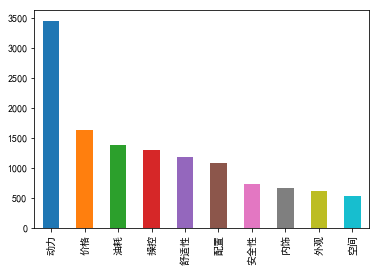

In [17]:
train_multi_sub_df = train_cut_df[['content_id', 'word', 'char', 'subject']]
train_multi_sub_df['subject'].value_counts().plot(kind='bar')

In [18]:
if '价格' not in train_multi_sub_df.columns:
    train_multi_sub_df = pd.concat((train_multi_sub_df, pd.get_dummies(train_multi_sub_df['subject'])), axis=1)

train_multi_sub_df = train_multi_sub_df.groupby(['content_id', 'word', 'char']).sum().reset_index(drop=False)
train_multi_sub_df[:3]

,content_id,word,char,价格,内饰,动力,外观,安全性,操控,油耗,空间,舒适性,配置
0,0,建议 定做 地毯 ， 还有 后尾...,建 议 定 做 地 毯 ， 还 ...,0,1,0,0,0,0,0,0,0,0
1,1,2.5 的 综合 油耗 好像 普...,2 . 5 的 综 合 油 耗 ...,0,0,0,0,0,0,1,0,0,0
2,2,确实 该 检查 了 ， 油耗 太...,确 实 该 检 查 了 ， 油 ...,0,0,0,0,0,0,1,0,0,0


In [19]:
train_multi_sub_df.to_csv('../../data/csvs/multi_sub_train.csv')
multi_sub_label_itos = list(train_multi_sub_df.iloc[:, 3:].columns)
pickle.dump(multi_sub_label_itos, open('../../data/multi_sub_label_itos.pkl', 'wb'))
multi_sub_label_itos

['价格', '内饰', '动力', '外观', '安全性', '操控', '油耗', '空间', '舒适性', '配置']

# 数据特征处理

## 2.1低频词过滤

In [20]:
# 训练数据少，不处理低频词
def construct_dict(df, d_type='word'):
    word_dict = {}
    corput = df.word if d_type == 'word' else df.char
    for line in tqdm(corput):
        for e in line.strip().split():
            word_dict[e] = word_dict.get(e, 0) + 1
    return word_dict
word_dict = construct_dict(train_df, d_type='word')
char_dict = construct_dict(train_df, d_type='char')
word_stop_word = set([e for e in word_dict if word_dict[e] <=0])
char_stop_word = set([e for e in char_dict if char_dict[e] <=0])
pickle.dump(set(word_stop_word), open('../../data/word_stopword.pkl', 'wb'))
pickle.dump(set(char_stop_word), open('../../data/char_stopword.pkl', 'wb'))

## 2.2合适长度选择

In [21]:
# 1000长度以内可以随意选，这里选最长的
# word单句合适长度 128
# char单句合适长度 200
def check_len(df, type='word'):
    s_dct = {}
    corpus = df.word if type == 'word' else df.char
    for s in corpus:
        s = [e for e in s.split() if e not in char_stop_word]
        s_dct[len(s)] = s_dct.get(len(s), 0) + 1
    l_lst = sorted(s_dct.items(), key=lambda x:x[0], reverse=False)
    sum(s_dct.values())
    p = 0.
    for l in l_lst:
        p += l[1] / sum(s_dct.values())
        print(str(l[0]) + '\t' + str(l[1]) + '\t' + str(p))
check_len(test_cut_df, 'char')
# check_len(test_cut_df, 'char')
# check_len(train_df_final, 'char')
# check_len(test_cut_df, 'char')
# len(train_cut_df)

9	1	0.0003632401017072285
10	3	0.001452960406828914
11	59	0.022884126407555393
12	57	0.04358881220486742
13	50	0.06175081729022884
14	62	0.08427170359607701
15	60	0.10606610969851071
16	62	0.12858699600435888
17	63	0.15147112241191427
18	90	0.18416273156556484
19	78	0.21249545949872867
20	70	0.23792226661823465
21	63	0.26080639302579006
22	59	0.28223755902651654
23	49	0.3000363240101707
24	67	0.324373410824555
25	49	0.3421721758082092
26	55	0.36215038140210676
27	38	0.37595350526698146
28	34	0.38830366872502725
29	56	0.40864511442063206
30	54	0.4282600799128224
31	38	0.4420632037776971
32	46	0.4587722484562296
33	41	0.47366509262622597
34	31	0.48492553577915004
35	52	0.5038140210679259
36	35	0.516527424627679
37	42	0.5317835088993825
38	47	0.5488557936796222
39	37	0.5622956774427896
40	39	0.5764620414093715
41	37	0.5899019251725389
42	34	0.6022520886305847
43	49	0.6200508536142388
44	32	0.6316745368688701
45	30	0.642571739920087
46	34	0.6549219033781327
47	41	0.6698147475481291
48	32	0

In [22]:
# 按句子分合适长度
# max_sent = 20
# max_word_len = 40
# max_char_len = 70
def check_lens(df):
    max_word = {}
    max_word_len = {}
    max_char = {}
    max_char_len = {}
    word = df.word
    char = df.char
    for w in word:
        sents = re.split(r" 。 | ， ", w.strip())
        max_word[len(sents)] = max_word.get(len(sents), 0) + 1
        for t in sents:
            max_word_len[len(t.split())] = max_word_len.get(len(t.split()), 0) + 1
    for c in char:
        sents = re.split(r" 。 | ， ", c.strip())
        max_char[len(sents)] = max_char.get(len(sents), 0) + 1
        for t in sents:
            max_char_len[len(t.split())] = max_char_len.get(len(t.split()), 0) + 1
    s_dct = max_char
    s_dct = max_word_len
    s_dct = max_char_len
    l_lst = sorted(s_dct.items(), key=lambda x:x[0], reverse=False)
    p = 0.
    for l in l_lst:
        p += l[1] / sum(s_dct.values())
        print(str(l[0]) + '\t' + str(l[1]) + '\t' + str(p))
#     print(max_word, max_word_len, max_char, max_char_len)
    
# check_lens(train_df_final)

## 2.3Word2vec模型训练

In [23]:
# 训练词向量
def train_w2v_model(type='char', min_freq=2, size=100):
    sentences = []

    if type == 'char':
        corpus = np.concatenate((train_cut_df['char'], test_cut_df['char']))
    elif type == 'word':
        corpus = np.concatenate((train_cut_df['word'], test_cut_df['word']))
    for e in tqdm(corpus):
        sentences.append([i for i in e.strip().split() if i])
    print('训练集语料:', len(corpus))
    print('总长度: ', len(sentences))
    model = Word2Vec(sentences, size=size, window=5, min_count=min_freq)
    model.itos = {}
    model.stoi = {}
    model.embedding = {}
    item_to_id = {}
    print('保存模型...')
    
#     print(sorted(list(model.wv.vocab.keys()), reverse=True))
    
    for k in tqdm(sorted(list(model.wv.vocab.keys()), reverse=True)):
        item_to_id[k] = model.wv.vocab[k].index
    os.makedirs('../../data/word2vec_models/', exist_ok=True)
    model.wv.save_word2vec_format('../../data/word2vec_models/word2vec.{}.{}d.model.txt'.format(type, size), binary=False)
    pickle.dump(item_to_id, open('../../data/{}_item_to_id.pkl'.format(type), 'wb'))
    words = model.wv.vocab
    with open('../../data/word2vec_models/word2vec.{}.{}d.vocab.txt'.format(type, size, min_freq),'w', encoding='UTF-8') as f:
        f.write('<S>\n</S>\n<UNK>\n')  # bilm-tf 要求vocab有这三个符号，并且在最前面
        for word in words:
            f.write(word+'\n')

    return model
# 比赛数据
model = train_w2v_model(type='char', min_freq=3, size=300)
model = train_w2v_model(type='word', min_freq=3, size=300)
# train_df[:3]
print('OK')


训练集语料: 15325
总长度:  15325
保存模型...
['�', '～', 'ｗ', 'ｖ', 'Ｔ', 'Ｌ', '？', '；', '：', '９', '８', '５', '４', '３', '２', '１', '０', '／', '．', '－', '，', '＋', '）', '（', '％', '！', '龟', '龙', '龄', '齿', '齐', '鼻', '鼠', '鼓', '鼎', '默', '黑', '黏', '黄', '麻', '麟', '麒', '麋', '鹿', '鹰', '鹏', '鸣', '鸡', '鸟', '鳍', '鲨', '鲜', '鲍', '鲁', '鱼', '魔', '魂', '鬼', '高', '髓', '骨', '骤', '骚', '骗', '骑', '骏', '验', '骂', '驾', '驼', '驻', '驶', '驴', '驱', '驰', '马', '香', '首', '馈', '饿', '饼', '饰', '饭', '饥', '餐', '飞', '飙', '飘', '风', '颠', '额', '颜', '题', '颗', '频', '颈', '颇', '领', '预', '顿', '顾', '须', '顺', '项', '顶', '页', '音', '韩', '韧', '鞋', '革', '面', '靠', '非', '静', '青', '霸', '露', '霉', '震', '需', '雾', '雷', '零', '雪', '雨', '集', '雅', '难', '隧', '障', '隙', '隔', '隐', '随', '陷', '陶', '陵', '陪', '险', '除', '院', '陡', '陕', '限', '降', '陋', '陈', '陆', '际', '附', '阿', '阻', '阶', '阵', '阳', '防', '队', '阔', '阅', '阁', '阀', '闻', '闹', '闷', '间', '闲', '问', '闭', '闪', '门', '长', '镜', '镙', '镑', '镇', '镀', '锻', '键', '锡', '错', '锐', '锋', '锈', '锅', '锁', '销', '链', '铺', '铸', '银', '铭', '铬', 


训练集语料: 15325
总长度:  15325
保存模型...
['�', '～', 'ｗ', 'ｖ', 'Ｔ', 'Ｌ', '？', '；', '：', '９', '８', '５', '４', '３', '２', '１', '０', '／', '．', '－', '，', '＋', '）', '（', '％', '！', '龙膜', '齿轮油', '齿轮', '齐全', '齐亮', '鼻子', '默认', '黑车', '黑色', '黑烟', '黑桶', '黑屏', '黑内', '黑', '黏度', '黄金', '黄色', '黄牛', '黄灯', '麻烦', '麻木', '麋鹿', '鹰眼', '鸡血', '鸡肋', '鸡爪', '鸡头', '鸡', '鸟样', '鳍', '鲨鱼', '鲍鱼', '鱼', '魔', '魂动', '鬼子', '高频', '高音', '高配', '高速路', '高速行驶', '高速公路', '高速', '高过', '高转速', '高转', '高车', '高级', '高粘度', '高等', '高端', '高科技', '高田', '高点', '高温', '高档', '高标号', '高架', '高是', '高手', '高性能', '高怠速', '高德', '高强度', '高度', '高峰期', '高峰', '高山', '高尔夫', '高富帅', '高大威猛', '高大', '高品质', '高原', '高压', '高功率', '高出', '高兴', '高低', '高位', '高价', '高些', '高于', '高不高', '高不低', '高', '骨架', '骗钱', '骗', '骑贱', '骑', '骏', '验车', '验证', '骂人', '骂', '驾龄', '驾驶舱', '驾驶者', '驾驶座', '驾驶室', '驾驶员', '驾驶', '驾过', '驾车', '驾校', '驾小森', '驾乘', '驾', '驻车', '驴', '驱车', '驱能', '驱动力', '驱动', '驱加', '驱', '驰鹏', '马驰宝', '马马虎虎', '马达', '马路', '马自达', '马牌', '马勒', '马力', '马云家', '马上', '马', '香水', '香槟金', '首页', '首选', '首要', '首先', '首保换


OK


## glove模型训练数据准备

In [ ]:
def data_prepare(type='word'):
    sentences = []
    if type == 'char':
        corpus = train_df_final['char']
    elif type == 'word':
        corpus = train_df_final['word']
    for e in tqdm(corpus):
        sentences.append(e)
    with open('../../data/{}.glove.txt'.format(type), 'w') as f:
        f.write(' '. join(sentences))
# data_prepare('word')
# data_prepare('char')

## TF-IDF特征训练